# Assignment 5 : Deep learning
<br>Last updated on 11/02/2023</br>


credit : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# print(transform)
batch_size = 32
trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
len(trainloader)

1250

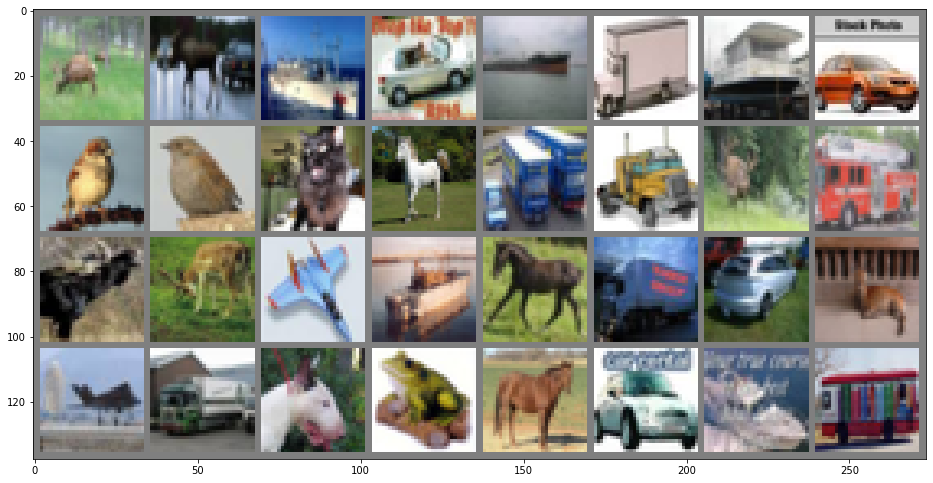

deer  deer  ship  car   ship  truck ship  car   bird  bird  cat   horse truck truck deer  truck deer  deer  plane ship  horse truck car   deer  plane truck dog   frog  horse car   ship  truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Model1: NN

Create a model to have an image of 32*32 pixels as an input with 10 output classes.

The model composes of flatten, dropout 20%, dense with 128 neurons, and output layer (with softmax) to classify each image into 10 classes.
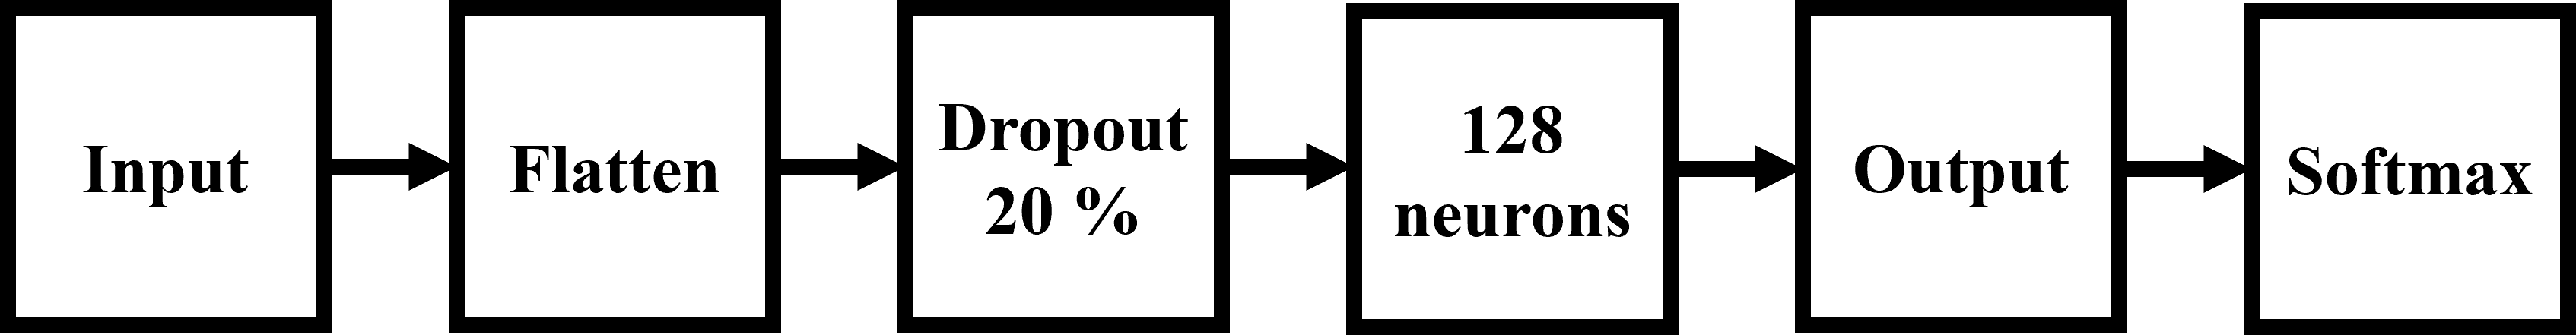

In [10]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        Insert your code here

        '''
        self.dropout_p = 0.2
        self.dropout = torch.nn.Dropout(p=self.dropout_p)
        self.dense128 = torch.nn.Linear(3*32*32, 128)
        self.head = torch.nn.Linear(128, 10)

    def forward(self, x):
        '''
        Insert your code here

        '''
        x = torch.flatten(x, 1)
        # x = F.relu(x)
        # print(x.shape)
        x = self.dropout(x)
        x = self.dense128(x)
        # print(x.shape)
        x = self.head(x)
        out = F.softmax(x)
        return out


net = Net().to(device)

In [17]:
from torchsummaryX import summary

summary(net,  torch.zeros((32, 3*32*32), dtype = torch.float).to(device) ) #summarize the model

           Kernel Shape Output Shape    Params Mult-Adds
Layer                                                   
0_dropout             -   [32, 3072]         -         -
1_dense128  [3072, 128]    [32, 128]  393.344k  393.216k
2_head        [128, 10]     [32, 10]     1.29k     1.28k
---------------------------------------------------------
                        Totals
Total params          394.634k
Trainable params      394.634k
Non-trainable params       0.0
Mult-Adds             394.496k


/var/folders/44/_pq_dlgs56q87kwfjb_4rl9r0000gn/T/ipykernel_31867/4147741959.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(x)
/opt/homebrew/lib/python3.10/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_dropout,-,"[32, 3072]",NaN,NaN
1_dense128,"[3072, 128]","[32, 128]",393344.0,393216.0
2_head,"[128, 10]","[32, 10]",1290.0,1280.0


Optimizer and criterion

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Training Model

In [23]:
PATH = './cifar_net.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    print("EPOCH :", epoch + 1)
    print("TRAINING LOOP")

    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        '''
        Insert your code here

        '''
        # print(inputs.shape)
        optimizer.zero_grad()
        Y_pred = net(inputs).to(device)
        # print(labels)
        # print(Y_pred)
        loss = criterion(Y_pred, labels).mean()
        # print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

        
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        print("VALIDATION LOOP")
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            '''
            Insert your code here

            '''
            Y_pred = net(inputs)
            running_val_loss = criterion(Y_pred, labels)

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

    # print("val loss:", avg_val_loss)
    # print("val accuracy:", val_acc)
    
print('Finished Training')
torch.save(net.state_dict(), PATH)

EPOCH : 1
TRAINING LOOP


/var/folders/44/_pq_dlgs56q87kwfjb_4rl9r0000gn/T/ipykernel_31867/4147741959.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(x)


[1,   100] loss: 0.115
[1,   200] loss: 0.115
[1,   300] loss: 0.115
[1,   400] loss: 0.115
[1,   500] loss: 0.115
[1,   600] loss: 0.115
[1,   700] loss: 0.115
[1,   800] loss: 0.115
[1,   900] loss: 0.115
[1,  1000] loss: 0.115
[1,  1100] loss: 0.115
[1,  1200] loss: 0.115
VALIDATION LOOP
Best model was saved at Epoch 0
EPOCH : 2
TRAINING LOOP
[2,   100] loss: 0.115
[2,   200] loss: 0.115
[2,   300] loss: 0.115
[2,   400] loss: 0.115
[2,   500] loss: 0.115
[2,   600] loss: 0.115
[2,   700] loss: 0.115
[2,   800] loss: 0.115
[2,   900] loss: 0.115
[2,  1000] loss: 0.115
[2,  1100] loss: 0.115
[2,  1200] loss: 0.115
VALIDATION LOOP
EPOCH : 3
TRAINING LOOP
[3,   100] loss: 0.115
[3,   200] loss: 0.115
[3,   300] loss: 0.115
[3,   400] loss: 0.115
[3,   500] loss: 0.115
[3,   600] loss: 0.115
[3,   700] loss: 0.115
[3,   800] loss: 0.115
[3,   900] loss: 0.115
[3,  1000] loss: 0.115
[3,  1100] loss: 0.115
[3,  1200] loss: 0.115
VALIDATION LOOP
EPOCH : 4
TRAINING LOOP
[4,   100] loss: 0.1

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Evaluation 

In [ ]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        '''
        Insert your code here

        '''

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

# Model2: CNN

Modify Model1:

Before the flatten layer, add 2 layers of Conv2D with kernel(2*2) for 32 and 64 filters with relu activation, respectively.
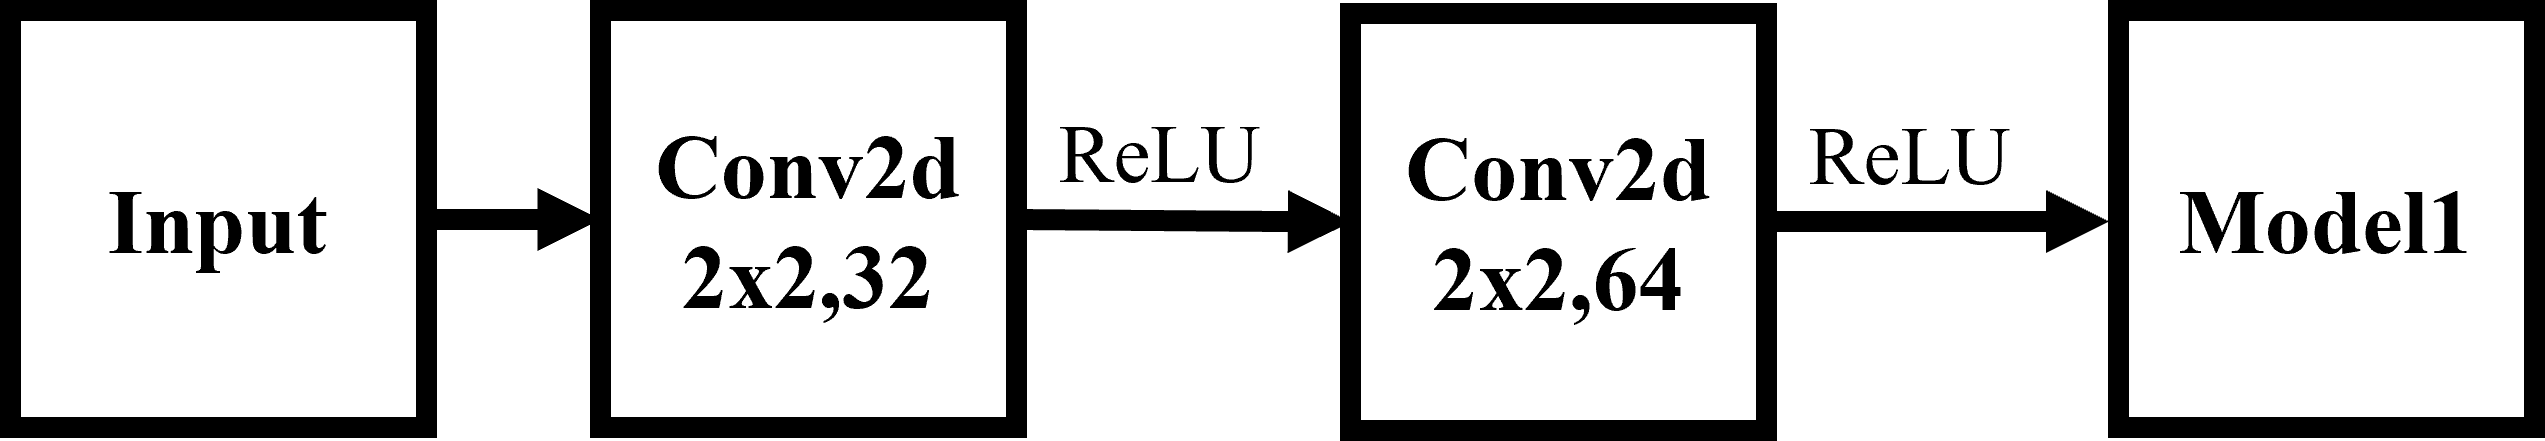

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        Insert your code here

        '''

    def forward(self, x):
        '''
        Insert your code here

        '''


net = CNN1().to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
PATH = './cifar_CNN1.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        '''
        Insert your code here

        '''
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            '''
            Insert your code here

            '''

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

In [ ]:
net = CNN1()
net.load_state_dict(torch.load(PATH))
net.to(device)

In [ ]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        '''
        Insert your code here

        '''

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)

# Model3: CNN with max-pool & dropout

Modify Model2:

After Conv2D layers in Model2, add MaxPooling2D with pooling size (2*2) and then dropout 30%.
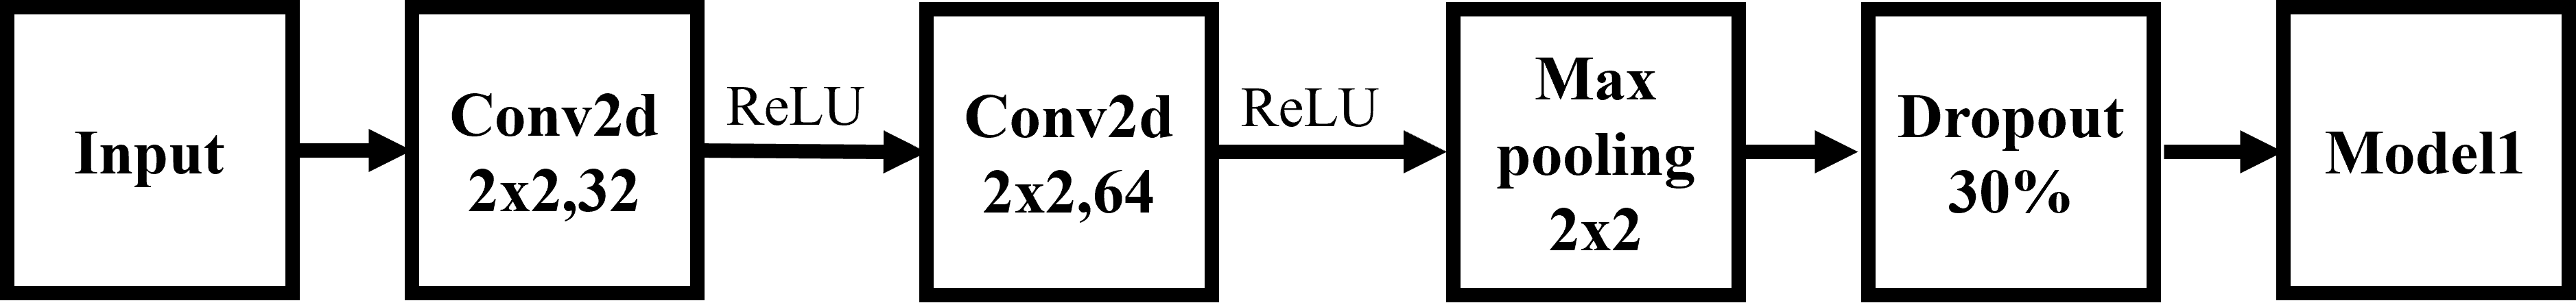

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        Insert your code here

        '''

    def forward(self, x):
        '''
        Insert your code here

        '''


net = CNN2()..to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
PATH = './cifar_CNN2.pth'
min_val_loss = 1e10
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    running_val_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        '''
        Insert your code here

        '''
    avg_loss = running_loss/len(trainloader)
    net.eval()
    with torch.no_grad():
        for i,data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            '''
            Insert your code here

            '''

        avg_val_loss = running_val_loss/len(valloader)

    if avg_val_loss < min_val_loss:
        torch.save(net.state_dict(), PATH)
        min_val_loss = avg_val_loss
        print(f"Best model was saved at Epoch {epoch}")

print('Finished Training')
torch.save(net.state_dict(), PATH)

In [ ]:
net = CNN2()
net.load_state_dict(torch.load(PATH))
net.to(device)

In [ ]:
predict = list()
label = list()
# since we're not training, we don't need to calculate the gradients for our outputs
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        '''
        Insert your code here

        '''

print("Classification report")
report = classification_report(label, predict,digits=4)
print(report)